In [ ]:
from google.colab import drive
import os
import shutil
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Project/solarPanelDefectDetection"

Bird-drop	Clean  Electrical-damage  Snow-Covered
Classification	Dusty  Physical-Damage


In [ ]:
import os

# Path to main dataset folder
main_folder = "/content/drive/MyDrive/Project/solarPanelDefectDetection"

# Your 6 class folders
classes = ['Bird-drop', 'Clean', 'Electrical-damage', 'Snow-Covered', 'Dusty', 'Physical-Damage']

# Valid image extensions
valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")

# Dictionary to store counts
image_counts = {}

# Loop through each class folder
for cls in classes:
    folder_path = os.path.join(main_folder, cls)
    if os.path.exists(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_extensions)]
        count = len(image_files)
        image_counts[cls] = count
        print(f"{cls}: {count} images")
    else:
        print(f"Folder not found: {cls}")

# Total images in all folders
total_images = sum(image_counts.values())
print(f"\nTotal images across all classes: {total_images}")


Bird-drop: 191 images
Clean: 193 images
Electrical-damage: 103 images
Snow-Covered: 123 images
Dusty: 190 images
Physical-Damage: 69 images

Total images across all classes: 869


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
import numpy as np
import random

# Paths
main_folder = "/content/drive/MyDrive/Project/solarPanelDefectDetection"
output_folder = "/content/drive/MyDrive/Project/solarPanelDefectDetection/augmented_dataset"
os.makedirs(output_folder, exist_ok=True)

# Classes
classes = ['Bird-drop', 'Clean', 'Electrical-damage', 'Snow-Covered', 'Dusty', 'Physical-Damage']

# Valid extensions
valid_extensions = (".jpg", ".jpeg", ".png")

# Data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Count images in each folder
counts = {}
for cls in classes:
    folder = os.path.join(main_folder, cls)
    files = [f for f in os.listdir(folder) if f.lower().endswith(valid_extensions)]
    counts[cls] = len(files)

max_count = max(counts.values())
print("Max count:", max_count)

# Augment each class to have max_count images
for cls in classes:
    input_folder = os.path.join(main_folder, cls)
    output_class_folder = os.path.join(output_folder, cls)
    os.makedirs(output_class_folder, exist_ok=True)

    files = [f for f in os.listdir(input_folder) if f.lower().endswith(valid_extensions)]
    current_count = len(files)
    print(f"\nAugmenting {cls}: {current_count} → {max_count}")

    i = 0
    while current_count + i < max_count:
        # Pick a random image to augment
        img_path = os.path.join(input_folder, random.choice(files))
        img = load_img(img_path)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        # Generate 1 augmented image at a time
        for batch in datagen.flow(x, batch_size=1):
            new_filename = f"aug_{i}_{os.path.basename(img_path)}"
            save_path = os.path.join(output_class_folder, new_filename)
            save_img(save_path, batch[0])
            i += 1
            if current_count + i >= max_count:
                break

    # Copy original images as well
    for f in files:
        src = os.path.join(input_folder, f)
        dst = os.path.join(output_class_folder, f)
        if not os.path.exists(dst):
            os.system(f'cp "{src}" "{dst}"')

print("\nAugmentation complete!")


Max count: 193

Augmenting Bird-drop: 191 → 193

Augmenting Clean: 193 → 193

Augmenting Electrical-damage: 103 → 193

Augmenting Snow-Covered: 123 → 193

Augmenting Dusty: 190 → 193

Augmenting Physical-Damage: 69 → 193

Augmentation complete!


In [ ]:
import os
import shutil
from math import floor

# Source folder (your balanced dataset)
source_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection/augmented_dataset"

# Destination folder
dest_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection/dataset_split"

# Splits
train_split = 0.7
val_split = 0.15
test_split = 0.15

# Valid extensions
valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")

# Create destination subfolders
splits = ['train', 'val', 'test']
for split in splits:
    split_path = os.path.join(dest_dir, split)
    os.makedirs(split_path, exist_ok=True)

# Loop through each class
classes = os.listdir(source_dir)
for cls in classes:
    class_path = os.path.join(source_dir, cls)
    if not os.path.isdir(class_path):
        continue

    # List and sort images
    images = sorted([f for f in os.listdir(class_path) if f.lower().endswith(valid_extensions)])
    n_total = len(images)

    # Calculate split sizes
    n_train = floor(train_split * n_total)
    n_val = floor(val_split * n_total)
    n_test = n_total - n_train - n_val  # remaining

    # Split lists
    train_files = images[:n_train]
    val_files = images[n_train:n_train + n_val]
    test_files = images[n_train + n_val:]

    # Create subfolders for each split
    for split, file_list in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        split_class_dir = os.path.join(dest_dir, split, cls)
        os.makedirs(split_class_dir, exist_ok=True)

        for file_name in file_list:
            src = os.path.join(class_path, file_name)
            dst = os.path.join(split_class_dir, file_name)
            shutil.copy2(src, dst)

    print(f"{cls}: {n_total} → train:{len(train_files)}, val:{len(val_files)}, test:{len(test_files)}")

print("\nDataset successfully split into train/val/test (70/15/15) in sorted order.")


Bird-drop: 193 → train:135, val:28, test:30
Clean: 193 → train:135, val:28, test:30
Electrical-damage: 193 → train:135, val:28, test:30
Snow-Covered: 193 → train:135, val:28, test:30
Dusty: 193 → train:135, val:28, test:30
Physical-Damage: 193 → train:135, val:28, test:30

Dataset successfully split into train/val/test (70/15/15) in sorted order.


Found 810 images belonging to 6 classes.
Found 168 images belonging to 6 classes.
Found 180 images belonging to 6 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training ResNet50...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 301s 11s/step - accuracy: 0.1633 - loss: 2.0396 - val_accuracy: 0.1845 - val_loss: 1.8420
Epoch 2/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 940ms/step - accuracy: 0.1761 - loss: 1.9739 - val_accuracy: 0.3393 - val_loss: 1.7846
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 939ms/step - accuracy: 0.2142 - loss: 1.8781 - val_accuracy: 0.3690 - val_loss: 1.7550
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 982ms/step - accuracy: 0.1836 - loss: 1.8926 - val_accuracy: 0.3571 - val_loss: 1.7401
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 931ms/step - accuracy: 0.2132 - loss: 1.8492 - val_accuracy: 0.3571 - val_loss: 1.7314
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 874ms/step - accuracy: 0.2212 - loss: 1.8365 - val_accuracy: 0.4226 - val_loss: 1.7232
Epoch 7/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 942ms/step - accuracy: 0.2145 - loss: 1.8716 - val_accuracy: 0.4167 - val_loss: 1.7152
Epoch 8/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 932ms/step - accuracy: 0.2231 - loss: 1.8420 - val_accur

ResNet50 Test Accuracy: 41.11%, Test Loss: 1.6497

Training VGG16...
Epoch 1/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.1754 - loss: 1.9906 - val_accuracy: 0.2798 - val_loss: 1.8843
Epoch 2/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 962ms/step - accuracy: 0.2202 - loss: 1.9049 - val_accuracy: 0.2679 - val_loss: 1.8494
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 980ms/step - accuracy: 0.1757 - loss: 1.9100 - val_accuracy: 0.2679 - val_loss: 1.8198
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 956ms/step - accuracy: 0.2016 - loss: 1.8468 - val_accuracy: 0.2798 - val_loss: 1.7947
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 985ms/step - accuracy: 0.2358 - loss: 1.8500 - val_accuracy: 0.2798 - val_loss: 1.7722
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 961ms/step - accuracy: 0.2046 - loss: 1.8362 - val_accuracy: 0.2917 - val_loss: 1.7527
Epoch 7/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 981ms/step - accuracy: 0.2111 - loss: 1.8036 - val_accuracy: 0.2976 - val_loss: 1.7356
Epoch 8/25
26/26 ━━━━━━━━━━━━━━

VGG16 Test Accuracy: 58.89%, Test Loss: 1.5404

Training InceptionV3...
Epoch 1/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.1827 - loss: 2.3031 - val_accuracy: 0.2024 - val_loss: 1.8143
Epoch 2/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 926ms/step - accuracy: 0.2035 - loss: 1.9885 - val_accuracy: 0.3036 - val_loss: 1.6164
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 934ms/step - accuracy: 0.2691 - loss: 1.7671 - val_accuracy: 0.4821 - val_loss: 1.4543
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 920ms/step - accuracy: 0.2883 - loss: 1.7650 - val_accuracy: 0.5952 - val_loss: 1.3169
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 887ms/step - accuracy: 0.3647 - loss: 1.6291 - val_accuracy: 0.6369 - val_loss: 1.2099
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 954ms/step - accuracy: 0.3630 - loss: 1.5799 - val_accuracy: 0.6786 - val_loss: 1.1228
Epoch 7/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 920ms/step - accuracy: 0.4492 - loss: 1.4250 - val_accuracy: 0.7024 - val_loss: 1.0471
Epoch 8/25
26/26 ━━━━━━━━━━━

InceptionV3 Test Accuracy: 80.56%, Test Loss: 0.6948

Training EfficientNetB0...
Epoch 1/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.1764 - loss: 1.8464 - val_accuracy: 0.1667 - val_loss: 1.7961
Epoch 2/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 918ms/step - accuracy: 0.1630 - loss: 1.8113 - val_accuracy: 0.2679 - val_loss: 1.7909
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 916ms/step - accuracy: 0.1885 - loss: 1.7898 - val_accuracy: 0.1667 - val_loss: 1.7905
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 965ms/step - accuracy: 0.1730 - loss: 1.7957 - val_accuracy: 0.1667 - val_loss: 1.7906
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 857ms/step - accuracy: 0.1924 - loss: 1.8067 - val_accuracy: 0.1548 - val_loss: 1.7904
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 894ms/step - accuracy: 0.1561 - loss: 1.8105 - val_accuracy: 0.1667 - val_loss: 1.7902
Epoch 7/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 917ms/step - accuracy: 0.1376 - loss: 1.8069 - val_accuracy: 0.1071 - val_loss: 1.7902
Epoch 8/25
26/26 ━━

EfficientNetB0 Test Accuracy: 29.44%, Test Loss: 1.7889

Training MobileNetV2...
Epoch 1/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.1310 - loss: 2.3200 - val_accuracy: 0.1726 - val_loss: 1.8459
Epoch 2/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 923ms/step - accuracy: 0.2353 - loss: 2.0577 - val_accuracy: 0.3214 - val_loss: 1.6380
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 872ms/step - accuracy: 0.2843 - loss: 1.8933 - val_accuracy: 0.4464 - val_loss: 1.4564
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 891ms/step - accuracy: 0.2925 - loss: 1.8255 - val_accuracy: 0.5179 - val_loss: 1.3029
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 915ms/step - accuracy: 0.4107 - loss: 1.5900 - val_accuracy: 0.6310 - val_loss: 1.1724
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 907ms/step - accuracy: 0.4018 - loss: 1.4930 - val_accuracy: 0.6905 - val_loss: 1.0689
Epoch 7/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 882ms/step - accuracy: 0.4173 - loss: 1.4885 - val_accuracy: 0.7262 - val_loss: 0.9868
Epoch 8/25
26/26 ━━

MobileNetV2 Test Accuracy: 78.33%, Test Loss: 0.6344

Training complete for all models!
Models and results saved in: /content/drive/MyDrive/Project/solarPanelDefectDetection/models
Summary CSV: /content/drive/MyDrive/Project/solarPanelDefectDetection/models/model_accuracy_summary.csv


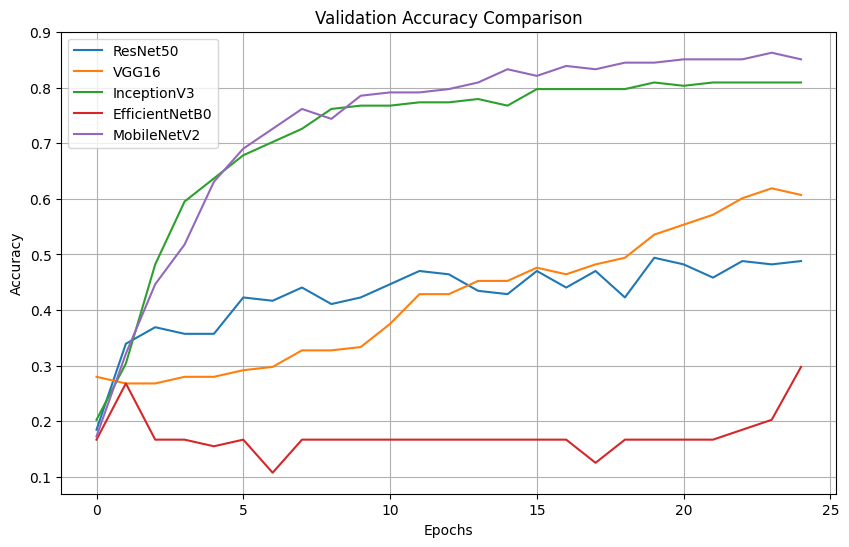

Validation accuracy plot saved as: /content/drive/MyDrive/Project/solarPanelDefectDetection/models/validation_accuracy_plot.png


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    ResNet50, VGG16, InceptionV3, EfficientNetB0, MobileNetV2
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd

base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection/dataset_split"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Folder to save models and plots
save_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection/models"
os.makedirs(save_dir, exist_ok=True)

img_size = (224, 224)
batch_size = 32
num_classes = 6
epochs = 25
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)
val_gen = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)
test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)
def build_model(base_model, num_classes=6):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model
models_to_train = {
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=img_size + (3,)),
    "VGG16": VGG16(weights='imagenet', include_top=False, input_shape=img_size + (3,)),
    "InceptionV3": InceptionV3(weights='imagenet', include_top=False, input_shape=img_size + (3,)),
    "EfficientNetB0": EfficientNetB0(weights='imagenet', include_top=False, input_shape=img_size + (3,)),
    "MobileNetV2": MobileNetV2(weights='imagenet', include_top=False, input_shape=img_size + (3,))
}
results = {}
summary_records = []

for name, base_model in models_to_train.items():
    print(f"\nTraining {name}...")

    base_model.trainable = False  # freeze pretrained layers
    model = build_model(base_model, num_classes)

    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        verbose=1
    )

    # Save model
    model_path = os.path.join(save_dir, f"{name}_model.h5")
    model.save(model_path)
    results[name] = history.history

    # Evaluate on test set
    loss, acc = model.evaluate(test_gen, verbose=0)
    print(f"{name} Test Accuracy: {acc*100:.2f}%, Test Loss: {loss:.4f}")

    summary_records.append({
        "Model": name,
        "Final_Train_Acc": history.history['accuracy'][-1],
        "Final_Val_Acc": history.history['val_accuracy'][-1],
        "Test_Acc": acc,
        "Test_Loss": loss
    })
summary_df = pd.DataFrame(summary_records)
summary_csv_path = os.path.join(save_dir, "model_accuracy_summary.csv")
summary_df.to_csv(summary_csv_path, index=False)

print("\nTraining complete for all models!")
print(f"Models and results saved in: {save_dir}")
print(f"Summary CSV: {summary_csv_path}")
plt.figure(figsize=(10,6))
for name, hist in results.items():
    plt.plot(hist['val_accuracy'], label=name)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plot_path = os.path.join(save_dir, "validation_accuracy_plot.png")
plt.savefig(plot_path)
plt.show()

print(f"Validation accuracy plot saved as: {plot_path}")


In [ ]:
import pandas as pd

csv_path = "/content/drive/MyDrive/Project/solarPanelDefectDetection/models/model_accuracy_summary.csv"
df = pd.read_csv(csv_path)

print("🔍 Column names in your file:")
print(df.columns.tolist())

print("\n📋 First few rows:")
print(df.head())


🔍 Column names in your file:
['Model', 'Final_Train_Acc', 'Final_Val_Acc', 'Test_Acc', 'Test_Loss']

📋 First few rows:
            Model  Final_Train_Acc  Final_Val_Acc  Test_Acc  Test_Loss
0        ResNet50         0.240741       0.488095  0.411111   1.649655
1           VGG16         0.409877       0.607143  0.588889   1.540426
2     InceptionV3         0.664198       0.809524  0.805556   0.694793
3  EfficientNetB0         0.196296       0.297619  0.294444   1.788894
4     MobileNetV2         0.711111       0.851190  0.783333   0.634424


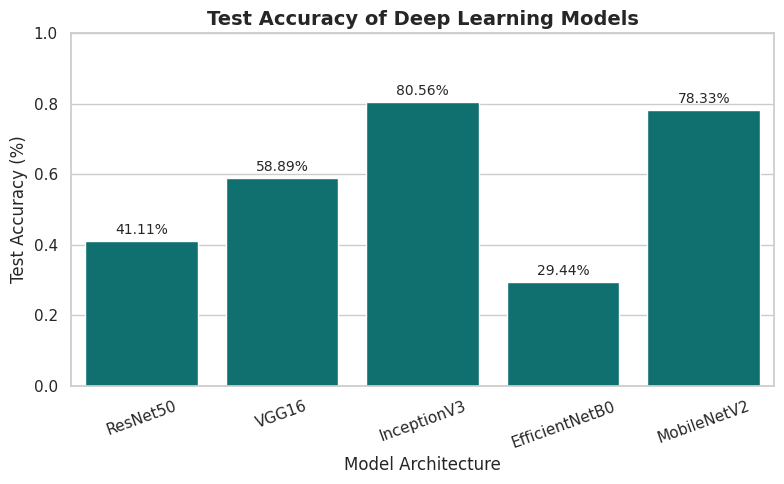

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =======================================================
# Load CSV
# =======================================================
csv_path = "/content/drive/MyDrive/Project/solarPanelDefectDetection/models/model_accuracy_summary.csv"
df = pd.read_csv(csv_path)

# =======================================================
# Plot setup
# =======================================================
sns.set(style="whitegrid", palette="crest")
plt.figure(figsize=(8, 5))

# Create bar plot for Test Accuracy
ax = sns.barplot(data=df, x="Model", y="Test_Acc", color="teal")

# =======================================================
# Titles and labels
# =======================================================
plt.title("Test Accuracy of Deep Learning Models", fontsize=14, fontweight='bold')
plt.xlabel("Model Architecture", fontsize=12)
plt.ylabel("Test Accuracy (%)", fontsize=12)
plt.ylim(0, 1.0)  # since your Test_Acc values are in 0–1 range
plt.xticks(rotation=20)

# =======================================================
# Add percentage labels on bars
# =======================================================
for container in ax.containers:
    ax.bar_label(container, labels=[f"{v*100:.2f}%" for v in df["Test_Acc"]],
                 label_type="edge", fontsize=10, padding=3)

plt.tight_layout()
plt.show()


Found 180 images belonging to 6 classes.
🔹 Loading ResNet50 model...


🔹 Loading VGG16 model...


🔹 Loading InceptionV3 model...


🔹 Loading EfficientNetB0 model...


🔹 Loading MobileNetV2 model...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



📊 Evaluating ResNet50...
ResNet50 — Test Accuracy: 41.11%, Test Loss: 1.6497
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step

📊 Evaluating VGG16...
VGG16 — Test Accuracy: 58.89%, Test Loss: 1.5404
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 672ms/step

📊 Evaluating InceptionV3...
InceptionV3 — Test Accuracy: 80.56%, Test Loss: 0.6948


6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step

📊 Evaluating EfficientNetB0...
EfficientNetB0 — Test Accuracy: 29.44%, Test Loss: 1.7889


6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step

📊 Evaluating MobileNetV2...
MobileNetV2 — Test Accuracy: 78.33%, Test Loss: 0.6344
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step

🔮 Creating Ensemble Model (Averaging Predictions)...

✅ Ensemble Model Test Accuracy: 80.56%

📋 Classification Report:
                   precision    recall  f1-score   support

        Bird-drop       0.78      0.47      0.58        30
            Clean       0.72      0.60      0.65        30
            Dusty       0.61      0.77      0.68        30
Electrical-damage       0.88      1.00      0.94        30
  Physical-Damage       0.97      1.00      0.98        30
     Snow-Covered       0.88      1.00      0.94        30

         accuracy                           0.81       180
        macro avg       0.81      0.81      0.80       180
     weighted avg       0.81      0.81      0.80       180



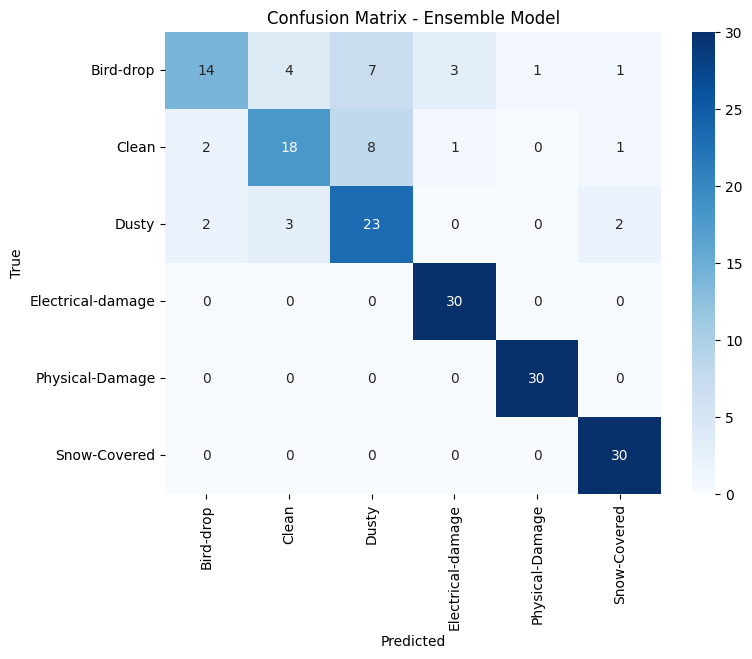


📈 Summary of Model Accuracies:
ResNet50: 41.11%
VGG16: 58.89%
InceptionV3: 80.56%
EfficientNetB0: 29.44%
MobileNetV2: 78.33%
Ensemble Model: 80.56%


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================================
# Paths
# ==========================================================
base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection/dataset_split"
test_dir = os.path.join(base_dir, "test")
models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection/models"

img_size = (224, 224)
batch_size = 32

# ==========================================================
# Load test data
# ==========================================================
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_labels = list(test_gen.class_indices.keys())

# ==========================================================
# Load all trained models
# ==========================================================
model_names = ["ResNet50", "VGG16", "InceptionV3", "EfficientNetB0", "MobileNetV2"]
models = []

for name in model_names:
    path = os.path.join(models_dir, f"{name}_model.h5")
    print(f"🔹 Loading {name} model...")
    model = tf.keras.models.load_model(path)
    models.append(model)

# ==========================================================
#  Evaluate each model individually
# ==========================================================
model_accuracies = {}
predictions = []

for i, model in enumerate(models):
    print(f"\nEvaluating {model_names[i]}...")
    loss, acc = model.evaluate(test_gen, verbose=0)
    print(f"{model_names[i]} — Test Accuracy: {acc*100:.2f}%, Test Loss: {loss:.4f}")
    model_accuracies[model_names[i]] = acc
    preds = model.predict(test_gen, verbose=1)
    predictions.append(preds)

# ==========================================================
#  Ensemble Prediction (Average Probabilities)
# ==========================================================
print("\n🔮 Creating Ensemble Model (Averaging Predictions)...")
avg_preds = np.mean(predictions, axis=0)
y_pred = np.argmax(avg_preds, axis=1)
y_true = test_gen.classes

# ==========================================================
# Ensemble Accuracy and Reports
# ==========================================================
ensemble_acc = accuracy_score(y_true, y_pred)
print(f"\nEnsemble Model Test Accuracy: {ensemble_acc*100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Ensemble Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ==========================================================
# Summary of all accuracies
# ==========================================================
print("\nSummary of Model Accuracies:")
for name, acc in model_accuracies.items():
    print(f"{name}: {acc*100:.2f}%")
print(f"Ensemble Model: {ensemble_acc*100:.2f}%")
